### Thesis Tilte: Spatial Synchronization Analysis for Detection of Epilepsy from Non-Invasive EEG

## Proposed Methods:

1. Segmentation of Time Interval for each label (siez,bckg)


In [1]:
import mne
import numpy as np
import pandas as pd
import os
import datetime
from mne.io.edf.edf import RawEDF

# Prepare data - Resampling - Windowing 

In [2]:
#TUH_EEG_SEIZURE_CORPUS = "/Users/jannis/Git/tuh-eeg-seizure-detection/data/raw"
#OUTPUT = "/Users/jannis/Git/tuh-eeg-seizure-detection/data/preprocessed"
TUH_EEG_SEIZURE_CORPUS = "c:/Users/mukht/Desktop/2020/DLND-Sessions/Activity/Activity-1/Research/tuh-eeg-seizure-detection-main/" #"/Users/jannis/Git/tuh-eeg-seizure-detection/data/raw"
OUTPUT = "c:/Users/mukht/Desktop/2020/DLND-Sessions/Activity/Activity-1/Research/tuh-eeg-seizure-detection-main/preprocessed4s" #"Users/jannis/Git/tuh-eeg-seizure-detection/data/preprocessed"
SAMPLING_FREQUENCY = 250
WINDOW_LENGTH = 3
CONFIGURATIONS = ["01_tcp_ar"]
CHANNELS = ["EEG FP1-REF", "EEG FP2-REF", "EEG F7-REF", "EEG F3-REF", "EEG F4-REF", "EEG F8-REF", "EEG T3-REF", "EEG C3-REF", "EEG C4-REF", "EEG T4-REF", "EEG T5-REF", "EEG P3-REF", "EEG P4-REF", "EEG T6-REF", "EEG O1-REF", "EEG O2-REF", "EEG CZ-REF", "EEG A1-REF", "EEG A2-REF"]

In [9]:
class Recording:
    path: str
    
    def __init__(self, path: str):
        self.path = path
    
    def load(self, channels: [str] = CHANNELS):
        raw = mne.io.read_raw_edf(self.path, preload=True)
        raw.pick(channels)
        
        annotations = self._parse_annotations()
        raw.set_annotations(annotations)
        
        return raw
            
    def _parse_annotations(self):
        annotation_file = self.path.replace(".edf", ".csv_bi")
        annotations: [str] = []
        
        with open(annotation_file, "r") as file:
            for line in file:
                annotations.append(line)
        
        annotations = annotations[6:]
        
        onset = []
        duration = []
        description = []
        
        for annotation in annotations:
            parts = annotation.split(",")
            start = float(parts[1])
            end = float(parts[2])
            label = parts[3]
            
            onset.append(start)
            duration.append(end - start)
            description.append(label)
            
        return mne.Annotations(onset, duration, description)
        
class Session:
    session_id: str
    recordings: [Recording]
    configuration: str
    
    def __init__(self, session_id: str, configuration: str):
        self.session_id = session_id
        self.configuration = configuration
        self.recordings = []
        
    def add_recording(self, recording: Recording):
        self.recordings.append(recording)
        
class Patient:
    patient_id: str
    sessions: [Session]
    
    def __init__(self, patient_id: str):
        self.patient_id = patient_id
        self.sessions = []
        
    def add_session(self, session: Session):
        self.sessions.append(session)
        
class Dataset:
    patients: [Patient]
    
    def __init__(self):
        self.patients = []
        
    def add_patient(self, patient: Patient):
        self.patients.append(patient)

In [22]:
def load_dataset(set_name: str, configurations: [str] = CONFIGURATIONS):
    path = f"{TUH_EEG_SEIZURE_CORPUS}/edf/{set_name}"
    dataset = Dataset()
    
    for patient_id in os.listdir(path):
        patient_path = f"{path}/{patient_id}"
        if not os.path.isdir(patient_path):
            continue
        
        patient = Patient(patient_id)
        
        for session_id in os.listdir(patient_path):
            session_path = f"{patient_path}/{session_id}"
            if not os.path.isdir(session_path):
                continue
            
            session = Session(session_id, set_name)
            
            for configuration in os.listdir(session_path):
                configuration_path = f"{session_path}/{configuration}"
                if not os.path.isdir(configuration_path) or configuration not in configurations:
                    continue
                    
                session.configuration = configuration
                
                for recording_id in os.listdir(configuration_path):
                    recording_path = f"{configuration_path}/{recording_id}"
                    if not os.path.isfile(recording_path) or not recording_path.endswith(".edf"):
                        continue
                    
                    recording = Recording(recording_path)
                    session.add_recording(recording) 
            
            if len(session.recordings) > 0:
                patient.add_session(session)
            
        if len(patient.sessions) > 0:
            dataset.add_patient(patient)
    print(len(patient.sessions))
    return dataset

In [23]:
dev_dataset = load_dataset("dev")
eval_dataset = load_dataset("eval")
train_dataset = load_dataset("train")
print(f"Dev set: {len(dev_dataset.patients)}")
print(f"Eval set: {len(eval_dataset.patients)}")
print(f"Train set: {len(train_dataset.patients)}")

2
3
5
Dev set: 41
Eval set: 41
Train set: 297


In [13]:
len(patients.sessions)

NameError: name 'patients' is not defined

In [6]:
# combine all datasets
dataset = Dataset()
dataset.patients = dev_dataset.patients + eval_dataset.patients + train_dataset.patients
print(f"Combined set: {len(dataset.patients)}")

Combined set: 379


In [ ]:
dataset.patients

In [14]:
# find patient with id aaaaamnk


In [ ]:
# get 10 patients, skip first 10 
patients = dataset.patients

for patient in patients:
    for session in patient.sessions:
        for recording in session.recordings:
            recording_name = recording.path.split("/")[-1].replace(".edf", "")
            recording_name = recording_name.split("_")[-1]
            
            raw = recording.load(CHANNELS)
            raw.resample(SAMPLING_FREQUENCY)
            
            seizure_samples = []
            #pre_seizure_samples = []
            non_seizure_samples = []
            
            for i in range(len(raw.annotations)):
                onset = raw.annotations[i]["onset"]
                duration = raw.annotations[i]["duration"]
                description = raw.annotations[i]["description"]
                
                # prevent overlong 
                if onset + duration > raw.times[-1]:
                    duration = raw.times[-1] - onset
                
                sample = raw.copy().crop(onset, onset + duration)
                
                if description == "bckg":
                    non_seizure_samples.append(sample)
                else:
                    seizure_samples.append(sample)
                    #pre_seizure_samples.append(sample)
                    
            if len(seizure_samples) == 0 and len(non_seizure_samples) == 0:
                continue
            
            os.makedirs(f"{OUTPUT}/{patient.patient_id}/seizures", exist_ok=True)
            os.makedirs(f"{OUTPUT}/{patient.patient_id}/non_seizures", exist_ok=True)
            #os.makedirs(f"{OUTPUT}/{patient.patient_id}/pre_seizures", exist_ok=True)
            
            for sample in seizure_samples:
                num_of_epochs = int(sample.times[-1] / WINDOW_LENGTH)
                for i in range(num_of_epochs):
                    epoch_path = f"{OUTPUT}/{patient.patient_id}/seizures/{session.session_id}_{recording_name}_{i}_raw.fif"
                   
                    # check if epoch already exists
                    if os.path.isfile(epoch_path):
                        continue
                    
                    start = i * WINDOW_LENGTH
                    end = start + WINDOW_LENGTH
                    epoch = sample.copy().crop(start, end)
                    
                    # sometimes measurement date is not set correctly -> we don't need it, so just set it to now
                    epoch.set_meas_date(datetime.datetime.now(datetime.UTC))
                    
                    epoch.save(epoch_path, overwrite=False)
                    
            
                    
            for sample in non_seizure_samples:
                num_of_epochs = int(sample.times[-1] / WINDOW_LENGTH)
                for i in range(num_of_epochs):
                    epoch_path = f"{OUTPUT}/{patient.patient_id}/non_seizures/{session.session_id}_{recording_name}_{i}_raw.fif"
                    
                    # check if epoch already exists
                    if os.path.isfile(epoch_path):
                        continue
                    
                    start = i * WINDOW_LENGTH
                    end = start + WINDOW_LENGTH
                    epoch = sample.copy().crop(start, end)
                    
                    # sometimes measurement date is not set correctly -> we don't need it, so just set it to now
                    epoch.set_meas_date(datetime.datetime.now(datetime.UTC))
                    
                    epoch.save(epoch_path, overwrite=False)

In [6]:
#search and save the events file 
import glob
sz_list=glob.glob('**/seizures/*.fif', recursive=True)
nonsz_list=glob.glob('**/non_seizures/*.fif', recursive=True)
#presz_list=glob.glob('**/pre_seizures/*.fif', recursive=True)
print(f"seizures set: {len(sz_list)}")
print(f"non seizures set: {len(nonsz_list)}")
#print(f"pre seizures set: {len(presz_list)}")

seizures set: 35192
non seizures set: 506820


# The Spectrum and EpochsSpectrum classes: frequency-domain data

This tutorial shows how to create and visualize frequency-domain representations of your
data, starting from continuous :class:`~mne.io.Raw`, discontinuous :class:`~mne.Epochs`,
or averaged :class:`~mne.Evoked` data.


In [1]:
# show non/siezure signals 
raw_bckg = mne.io.read_raw_fif(nonsz_list[200], preload=True)
raw_sz = mne.io.read_raw_fif(sz_list[200], preload=True)
bckg_spec = raw_bckg.compute_psd(method='welch', tmin=0.1, tmax=3, fmin=2, fmax=45, picks="eeg")
siez_spec = raw_sz.compute_psd(method='welch', tmin=0.1, tmax=3, fmin=2, fmax=45, picks="eeg")
raw.plot()

NameError: name 'mne' is not defined

In [156]:
bckg_spec = raw_bckg.compute_psd(method='welch', tmin=0.1, tmax=3, fmin=2, fmax=45, picks="eeg")
siez_spec = raw_sz.compute_psd(method='welch', tmin=0.1, tmax=3, fmin=2, fmax=45, picks="eeg")

Effective window size : 2.904 (s)
Effective window size : 2.904 (s)


Plotting power spectral density (dB=True).


C:\Users\mukht\AppData\Local\Temp\ipykernel_41372\1049454998.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  bckg_spec.plot(picks="data", exclude="bads", amplitude=False)
C:\Users\mukht\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


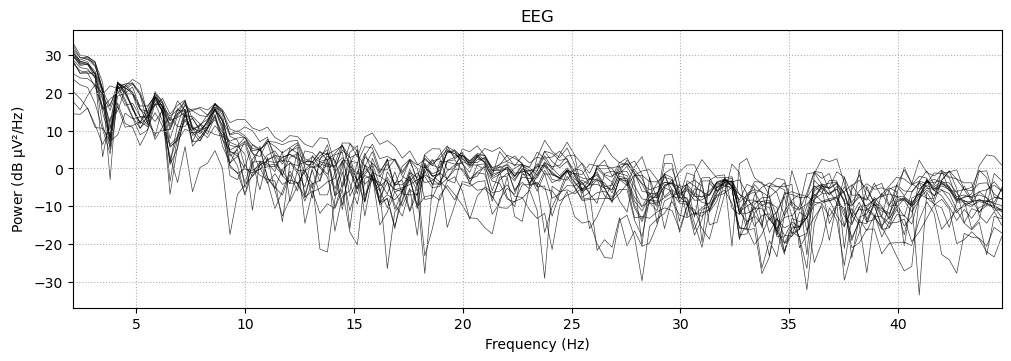

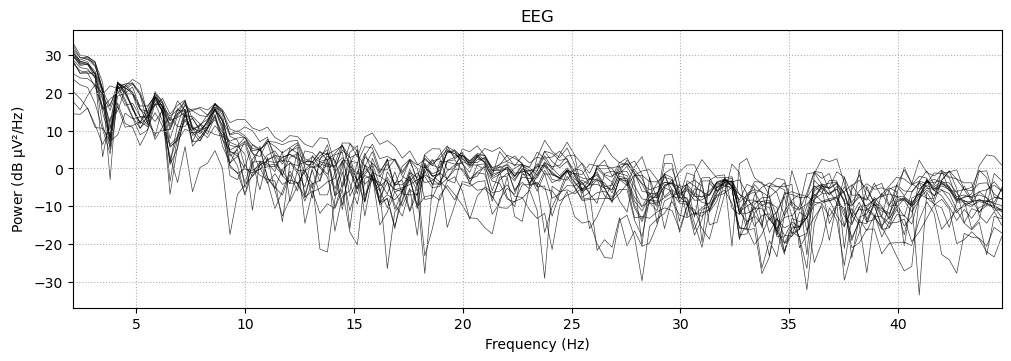

In [158]:
bckg_spec.plot(picks="data", exclude="bads", amplitude=False)
#bckg_spec.plot_topo(color="k", fig_facecolor="w", axis_facecolor="w")

Plotting amplitude spectral density (dB=True).


C:\Users\mukht\AppData\Local\Temp\ipykernel_41372\1542296917.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  siez_spec.plot(picks="data", exclude="bads", amplitude=True)
C:\Users\mukht\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


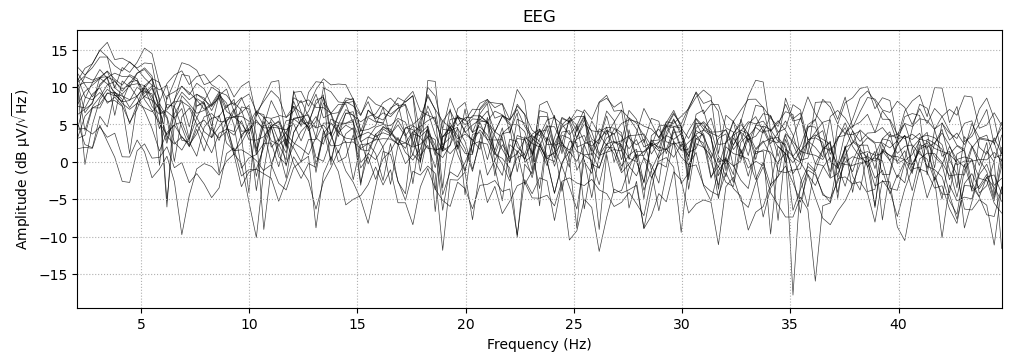

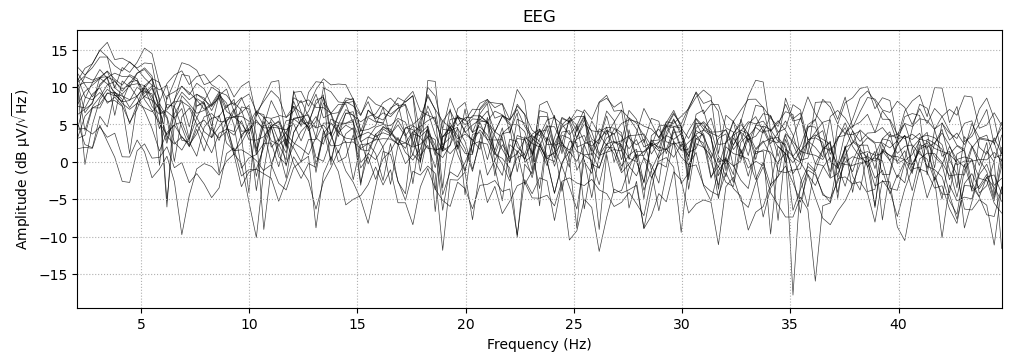

In [159]:
siez_spec.plot(picks="data", exclude="bads", amplitude=True)

In [160]:
bckg_spec.plot_topomap(ch_type="eeg", agg_fun=np.median)

RuntimeError: No digitization points found.

# Feature Extraction 
1. Wavelet 
2. PSD with SSD

In [161]:
import pywt
%matplotlib qt

import matplotlib.pyplot as plt

# extract wavelet features
def extract_wavelet_features(raw:nonsz_list[2], channels=CHANNELS):
    features = []
    raw = mne.io.read_raw_fif(sz_list[20], preload=True)
    for channel in channels:
        data = raw.copy().pick(channel).get_data()[0]
        coeffs = pywt.wavedec(data, 'db4', level=4)
        features.append(coeffs)
        
    return features

features = extract_wavelet_features(sz_list[20])
[phi, psi, x] = pywt.Wavelet('db1').wavefun(level=1) 

#fig, axs = plt.subplots(0,len(features), figsize=(15, 10))
#for j, band in enumerate(features):
#    axs[0, j].plot(band)
#    axs[0, j].set_title(f'Band {j+1}')
#plt.tight_layout()
#plt.show()

Opening raw data file preprocessed3s\aaaaaaaq\seizures\s006_2014_t000_118_raw.fif...
Isotrak not found
    Range : 534992 ... 535742 =   2139.968 ...  2142.968 secs
Ready.
Reading 0 ... 750  =      0.000 ...     3.000 secs...


In [ ]:
wtsz_features = []
wtbkg_features = []
def extract_wavelet_features(raw:nonsz_list[2], channels=CHANNELS):
    features = []
    raw = mne.io.read_raw_fif(sz_list[20], preload=True)
    for channel in channels:
        data = raw.copy().pick(channel).get_data()[0]
        coeffs = pywt.wavedec(data, 'db16', level=0)
        features.append(coeffs)
        
    return features
for i in range(len(sz_list[:35000])):
    wtsz_features.append(extract_wavelet_features(sz_list[i]))
    wtbkg_features.append(extract_wavelet_features(nonsz_list[i]))
    

In [151]:
# wavelet features
wtsz_features = np.squeeze(wtsz_features)
wtbkg_features = np.squeeze(wtbkg_features)

np.shape(wtbkg_features)

(35000, 19, 751)

In [ ]:



for i in range(len(sz_list[:10000])):
    raw = mne.io.read_raw_fif(sz_list[i], preload=True)
    data = raw.copy().get_data()[0]
    coeffs = pywt.wavedec(data, 'db4', level=4)
    wtsz_features.append(coeffs)

for i in range(len(nonsz_list[:15000])):
    raw = mne.io.read_raw_fif(nonsz_list[i], preload=True)
    data = raw.copy().get_data()[0]
    coeffs = pywt.wavedec(data, 'db4', level=4)
    wtbkg_features.append(coeffs)

In [ ]:
wtbkg_features[1000]

### PSD Estimation

In [ ]:
import matplotlib.pyplot as plt

import mne
from mne import Epochs
from mne.datasets.fieldtrip_cmc import data_path
from mne.decoding import SSD
psd_sz = []
psd_nonsz = []
for i in range(len(sz_list[:35000])):
    raw_bckg = mne.io.read_raw_fif(nonsz_list[i], preload=True)
    raw_sz = mne.io.read_raw_fif(sz_list[i], preload=True)
    bckg_spec = raw_bckg.compute_psd(method='welch', tmin=0, tmax=3, fmin=2, fmax=47, picks="eeg").get_data()
    siez_spec = raw_sz.compute_psd(method='welch', tmin=0, tmax=3, fmin=2, fmax=47, picks="eeg").get_data()
    psd_sz.append(siez_spec)
    psd_nonsz.append(bckg_spec)

import pandas as pd
psd_sum_sz = []
psd_sum_nonsz = []
for i in range(len(psd_sz)):
    
    psd_sum_sz.append(np.sum(psd_sz[i],axis=0))
    psd_sum_nonsz.append(np.sum(psd_nonsz[i],axis=0))
    
np.shape(psd_sum_sz)
np.shape(psd_sz)

In [51]:
np.shape(psd_sum_sz)

(1, 135)

### PSD + SSD

In [ ]:
import matplotlib.pyplot as plt

import mne
from mne import Epochs
from mne.datasets.fieldtrip_cmc import data_path
from mne.decoding import SSD
# Prepare data
#raw = mne.io.read_raw_ctf(fname)
#raw.crop(50.0, 110.0).load_data()  # crop for memory purposes
#raw.resample(sfreq=250)

psd_sz = []

for i in range(len(sz_list[:35000])):
    
        raw = mne.io.read_raw_fif(sz_list[i], preload=True)
        #raw.pick_types(meg=True, ref_meg=False)
        
        freqs_sig = 2, 45
        freqs_noise = 1, 47
        
        
        ssd = SSD(
            info=raw.info,
            reg="oas",
            sort_by_spectral_ratio=False,  # False for purpose of example.
            filt_params_signal=dict(
                l_freq=freqs_sig[0],
                h_freq=freqs_sig[1],
                l_trans_bandwidth=1,
                h_trans_bandwidth=1,
            ),
            filt_params_noise=dict(
                l_freq=freqs_noise[0],
                h_freq=freqs_noise[1],
                l_trans_bandwidth=1,
                h_trans_bandwidth=1,
            ),
        )
        ssd.fit(X=raw.get_data())
        # Transform
        ssd_sources = ssd.transform(X=raw.get_data())
        
        # Get psd of SSD-filtered signals.
        psd, freqs = mne.time_frequency.psd_array_welch(ssd_sources, sfreq=raw.info["sfreq"], n_fft=250)
        #print(np.sum(psd))
        psd_sz.append(psd)
        


In [97]:
np.shape(psd_sz)

(35000, 19, 126)

In [ ]:
psd_nonsz = []

for i in range(len(nonsz_list[:50000])):
    
        raw = mne.io.read_raw_fif(nonsz_list[i], preload=True)
        #raw.pick_types(meg=True, ref_meg=False)
        
        freqs_sig = 2, 45
        freqs_noise = 1, 47
        
        
        ssd = SSD(
            info=raw.info,
            reg="oas",
            sort_by_spectral_ratio=False,  # False for purpose of example.
            filt_params_signal=dict(
                l_freq=freqs_sig[0],
                h_freq=freqs_sig[1],
                l_trans_bandwidth=1,
                h_trans_bandwidth=1,
            ),
            filt_params_noise=dict(
                l_freq=freqs_noise[0],
                h_freq=freqs_noise[1],
                l_trans_bandwidth=1,
                h_trans_bandwidth=1,
            ),
        )
        ssd.fit(X=raw.get_data())
        # Transform
        ssd_sources = ssd.transform(X=raw.get_data())
        
        # Get psd of SSD-filtered signals.
        psd, freqs = mne.time_frequency.psd_array_welch(
            ssd_sources, sfreq=raw.info["sfreq"], n_fft=250)
        psd_nonsz.append(psd)

In [100]:
np.shape(psd_nonsz)

(50000, 19, 126)

In [103]:
np.shape(np.sum(psd_sz[1],axis=0))

(126,)

## summation of psd for each channel

In [104]:
# summation of psd for each channel

import pandas as pd
psd_sum_sz = []
psd_sum_nonsz = []
for i in range(len(psd_sz)):
    
    psd_sum_sz.append(np.sum(psd_sz[i],axis=0))
    psd_sum_nonsz.append(np.sum(psd_nonsz[i],axis=0))
    
np.shape(psd_sum_sz)

(35000, 126)

# summation of wavelet db16 features for each channel

In [152]:
# summation of wavelet db16 features for each channel

wtsz_features
wtbkg_features
import pandas as pd
wtsz_sum_features = []
wtbkg_sum_features = []
for i in range(len(psd_sz)):
    
    wtsz_sum_features.append(np.sum(wtsz_features[i],axis=0))
    wtbkg_sum_features.append(np.sum(wtbkg_features[i],axis=0))
    
np.shape(wtsz_sum_features)

(35000, 751)

# Adding Features to Dataframe 

In [67]:
import pandas as pd
df_feat_sz = pd.DataFrame(psd_sum_sz)
df_feat_sz['Label'] = "seiz" #'pre-seiz' # adding the label
df_feat_sz.head()

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,Label
0,5.044825e-09,3.709977e-09,2.457321e-09,2.032195e-09,1.908694e-09,2.402420e-09,1.669013e-09,8.551709e-10,7.861083e-10,6.294988e-10,...,3.885132e-12,4.009108e-12,1.120399e-11,6.190497e-12,4.851924e-12,4.551767e-12,3.825392e-12,5.920425e-12,4.875355e-12,seiz
1,4.433581e-10,3.466663e-10,4.215710e-10,3.855069e-10,5.777234e-10,3.966317e-10,7.129298e-10,6.471330e-10,4.614710e-10,4.161293e-10,...,1.048079e-11,1.817727e-11,2.481222e-11,1.588238e-11,1.640353e-11,1.095076e-11,1.124063e-11,1.159236e-11,1.038917e-11,seiz
2,1.831802e-09,1.286575e-09,3.219164e-10,4.081648e-10,6.517537e-10,1.001691e-09,7.912267e-10,4.424931e-10,1.314910e-09,6.055107e-10,...,8.243761e-11,8.109645e-11,3.353832e-11,2.711127e-11,3.205932e-11,3.567222e-11,3.959401e-11,1.276836e-11,4.050898e-11,seiz
3,5.000182e-10,1.129193e-09,6.782764e-10,2.704687e-10,2.516975e-10,4.302569e-10,2.870670e-10,5.866984e-10,4.837803e-10,8.155414e-10,...,3.465653e-11,3.257951e-11,2.126497e-11,3.711806e-11,4.433676e-11,1.321992e-11,3.940170e-11,5.174646e-11,6.907862e-11,seiz
4,2.240074e-09,2.424439e-09,1.451313e-09,8.035769e-10,3.573732e-10,2.696202e-10,3.157574e-10,5.666947e-11,3.945104e-10,5.036050e-10,...,2.072786e-11,3.015779e-11,1.742636e-11,7.621623e-12,1.428605e-11,1.159828e-11,1.346502e-11,2.421237e-11,2.826635e-11,seiz


In [68]:
df_feat_nonsz = pd.DataFrame(psd_sum_nonsz)
df_feat_nonsz['Label'] = "Non_seiz" #'pre-seiz' # adding the label
df_feat_nonsz.head()

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,Label
0,5.408672e-09,5.336267e-09,1.611081e-09,9.981876e-11,3.707359e-10,1.392253e-09,3.137264e-09,2.425433e-09,8.217946e-10,1.249004e-09,...,6.274383e-12,1.199494e-11,1.529290e-11,1.268777e-11,2.935263e-11,1.429497e-11,3.739436e-11,3.672897e-11,1.145019e-11,Non_seiz
1,2.528371e-09,5.402938e-09,2.571412e-09,7.518472e-10,6.846983e-10,4.190331e-10,2.083367e-10,3.712784e-10,9.698520e-10,3.706681e-10,...,2.443496e-13,2.327306e-13,2.085372e-13,3.173543e-13,3.005638e-13,3.577746e-13,4.268241e-13,3.854469e-13,3.887900e-13,Non_seiz
2,6.620449e-10,1.160047e-09,3.867686e-09,1.240681e-09,3.707056e-10,2.033635e-10,7.244933e-10,1.345903e-09,1.150626e-09,6.512078e-10,...,4.283049e-13,6.114374e-13,5.027821e-13,4.967308e-13,8.728368e-13,1.278051e-12,5.751377e-13,2.170088e-13,5.060378e-13,Non_seiz
3,2.467289e-09,1.731945e-09,7.394919e-10,5.119048e-10,3.141478e-10,6.558844e-10,2.231825e-10,1.738822e-10,2.863994e-10,1.180931e-09,...,1.633812e-13,2.406364e-13,4.151422e-13,5.351949e-13,3.746533e-13,4.084766e-13,1.734970e-13,1.811853e-13,6.326460e-13,Non_seiz
4,6.804417e-09,2.417557e-09,6.686645e-10,1.232817e-09,8.614560e-10,3.069557e-10,7.154772e-10,1.231900e-09,1.132790e-09,3.986729e-10,...,5.523520e-13,2.052569e-13,2.305355e-13,1.882785e-13,2.021818e-13,4.027622e-13,4.973219e-13,9.775905e-13,1.149377e-12,Non_seiz


In [69]:
#merge two dataframe in one 
dataset_feat = pd.concat([df_feat_sz,df_feat_nonsz])

dataset_feat = dataset_feat.sample(frac=1)
dataset_feat.head(30)

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,Label
6516,2.177658e-10,4.561743e-11,6.754178e-11,7.018375e-11,1.821712e-10,2.768135e-10,7.794483e-11,1.564454e-11,3.638131e-11,1.038418e-10,...,3.211044e-12,2.902217e-12,3.121145e-12,2.414769e-12,1.642059e-12,1.947220e-12,2.632890e-12,4.727642e-12,3.543145e-12,Non_seiz
25637,3.746522e-11,1.053845e-11,2.720269e-11,6.146604e-11,8.580948e-11,8.246897e-11,2.563492e-11,2.436267e-11,1.397213e-11,2.937932e-11,...,7.416835e-12,5.676627e-12,1.043353e-11,1.718817e-11,7.517259e-13,5.588377e-12,1.973598e-11,1.066382e-11,1.138022e-11,Non_seiz
12729,1.369302e-10,9.212413e-11,4.755327e-11,4.618340e-11,6.176001e-11,8.617149e-11,1.157887e-10,1.234077e-10,7.733506e-11,1.462060e-10,...,1.147578e-11,5.011654e-12,6.540230e-12,7.336037e-12,8.896602e-12,1.579192e-11,5.297680e-12,9.638353e-12,8.197611e-12,seiz
4722,8.192664e-10,5.813324e-10,3.549770e-10,1.184553e-10,4.763392e-11,2.404449e-10,1.012053e-10,2.929490e-10,2.489160e-10,3.530475e-11,...,7.108341e-13,3.429661e-12,2.892405e-12,4.994494e-12,2.820271e-12,2.775424e-12,1.661441e-11,4.016122e-11,2.034101e-11,seiz
30559,9.458236e-10,4.286172e-10,7.185780e-10,1.953005e-09,2.388284e-09,5.855385e-10,1.723480e-09,6.077911e-10,3.443951e-10,1.711716e-10,...,8.996319e-12,1.326914e-11,1.161424e-11,2.707356e-11,3.311346e-11,4.925065e-11,2.025944e-11,1.997641e-11,1.249264e-11,seiz
2687,1.703146e-10,1.143591e-10,1.147942e-10,8.145618e-11,2.257109e-11,2.593926e-11,1.620980e-11,2.785355e-11,8.646754e-12,3.924508e-11,...,1.467109e-11,4.422705e-12,1.866678e-12,1.617327e-12,4.235476e-12,8.788193e-12,7.058277e-12,4.270224e-12,9.960892e-12,Non_seiz
14007,5.272310e-10,9.328746e-10,3.990240e-09,1.356170e-09,7.333843e-10,2.465868e-09,1.886353e-09,9.392016e-10,5.461568e-10,2.579625e-10,...,1.166101e-10,6.980281e-11,7.481110e-11,1.396019e-10,1.027063e-10,1.129561e-10,1.016310e-10,5.956353e-11,1.696922e-10,seiz
14189,1.968697e-09,1.303574e-10,5.471920e-10,2.386120e-10,1.286167e-10,4.863333e-10,3.932802e-10,1.432306e-10,5.963612e-10,3.176013e-10,...,8.346174e-12,1.019183e-11,3.406754e-11,2.386722e-11,4.106360e-11,1.627310e-11,1.512801e-11,1.395068e-11,3.523468e-11,seiz
22289,9.150440e-10,8.712782e-10,5.695918e-10,3.642311e-10,2.613244e-10,1.307787e-10,9.178376e-11,7.033314e-11,4.623549e-11,6.584532e-11,...,4.059126e-11,1.831130e-11,3.740524e-11,6.128326e-11,2.425080e-11,3.247676e-11,3.408114e-11,2.693873e-11,2.068516e-11,Non_seiz
29557,5.043468e-10,4.284295e-10,2.486161e-10,6.261781e-10,9.674181e-11,2.817015e-10,3.830249e-10,6.481051e-11,5.952721e-11,2.970038e-11,...,1.184407e-11,4.876066e-12,8.999559e-12,9.734600e-12,1.205048e-11,2.351421e-11,9.590201e-12,1.394309e-11,6.696876e-12,Non_seiz


# Save dataset to CSV

In [70]:
dataset_feat.to_csv('dataset_psd3s70k40hz.csv', index=False)

# Reading CSV Dataset

In [3]:
import pandas as pd
dataset_feat = pd.read_csv('dataset_feat3s85k40hz.csv')  

In [4]:
dataset_feat.shape

(70000, 127)

In [5]:
dataset_feat = dataset_feat.sample(frac=1)
dataset_feat.head(10)

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,Label
12813,2.242209,20.954163,23.514928,18.779760,12.757776,7.389695,6.475159,11.117609,16.156635,10.812024,...,3.100911,6.286446,246.556637,738.992928,76.653144,8.971988,4.598583,2.991718,0.751538,Non_seiz
68509,2.284252,32.072249,25.698603,14.132549,7.336815,4.464179,3.216628,3.294627,4.189334,2.415583,...,1.542234,1.585131,1.068489,1.024841,0.682727,0.427768,0.484293,0.661048,0.300021,Non_seiz
20096,1.140905,11.485577,7.700812,6.003306,6.447152,6.093134,5.460692,6.438952,7.613011,7.440702,...,1.383864,1.288569,1.146750,1.680987,1.481039,1.258538,1.154860,1.439659,0.490648,Non_seiz
32858,2.381000,30.593123,85.477979,46.740719,22.778800,16.860173,10.415824,7.615610,9.340376,7.154255,...,0.418068,0.528865,1.110200,2.810949,0.895522,0.574523,0.731361,0.778952,0.223831,seiz
37703,1.750987,19.466381,47.856369,51.158543,41.957349,41.079276,40.814887,70.698500,62.325010,30.218430,...,1.351023,0.958930,1.752331,3.741930,1.894253,1.276287,1.472110,1.039243,0.337815,Non_seiz
64040,2.937953,41.959325,191.993635,308.569222,202.912261,135.728644,90.595583,47.968612,33.229781,32.983221,...,0.162146,0.157704,1.445266,7.831791,2.122096,0.157441,0.112179,0.204668,0.130784,seiz
48283,2.520856,25.049636,73.801892,77.418159,41.878160,28.715408,44.563887,53.049004,65.375539,49.783952,...,0.033868,0.021187,0.021556,0.014162,0.008609,0.006180,0.009752,0.008711,0.002585,Non_seiz
17165,1.480754,22.157594,22.339155,21.640491,24.004371,15.766550,16.812113,24.494184,20.842391,7.180547,...,0.249639,0.360363,0.321867,0.403438,0.311000,0.358920,0.288230,0.294538,0.124580,seiz
44001,0.196231,1.835283,1.299524,0.984630,1.335292,7.267414,4.963563,2.413025,2.018659,1.495592,...,0.016605,0.010911,0.052826,0.104470,0.024423,0.004014,0.013513,0.025679,0.012087,seiz
56029,2.976928,20.996329,15.490054,12.824028,9.001748,5.008194,4.313955,3.860018,3.903024,6.096492,...,0.082579,0.035246,0.047262,0.098587,0.045214,0.033657,0.038475,0.033421,0.011056,Non_seiz


In [5]:
#dataset_feat.columns= ["EEG FP1-REF", "EEG FP2-REF", "EEG F7-REF", "EEG F3-REF", "EEG F4-REF", "EEG F8-REF", "EEG T3-REF", "EEG C3-REF", "EEG C4-REF", "EEG T4-REF", "EEG T5-REF", "EEG P3-REF", "EEG P4-REF", "EEG T6-REF", "EEG O1-REF", "EEG O2-REF", "EEG CZ-REF", "EEG A1-REF", "EEG A2-REF","Label"]
#dataset_feat.head()

In [ ]:
## rondomize the dataset
data = dataset_feat.sample(frac=1)

# Separate the data into features and targets
target = data["Label"].replace({"seiz":1,"Non_seiz":0})
features, targets = data.drop(["Label"], axis=1), target


In [19]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [20]:
pca, feartures_pca = do_pca(n_components = 40, data = features)

### Splitting the data into training, testing, and validation sets

In [21]:

# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feartures_pca, 
                                                    targets, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 56000 samples.
Testing set has 14000 samples.


In [22]:
y_train.head(10)

63837    1
63648    1
1922     1
60806    1
8984     0
66414    1
10474    1
20074    0
51694    0
20493    1
Name: Label, dtype: int64

In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [15]:
pca, X_pca = do_pca(n_components=45, data=features)

In [18]:
X_pca.shape

(70000, 45)

In [24]:
# TODO: Calculate accuracy, precision and recall
accuracy = np.sum(target == 1)/len(target)
recall = 1
precision = accuracy

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+0.5**2)*(precision*recall)/((0.5**2 * precision)+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.5000, F-score: 0.5556]


### Applying Machine Learning 

In [25]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 3000 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:56000])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:56000], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    #results['f_train'] = fbeta_score(y_train[:300], predictions_train, 0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    #results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [10]:
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import vpython as vs

# Pretty display for notebooks
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
# TODO: Initialize the three models
clf_A = RandomForestClassifier(random_state = 42)
clf_B = GradientBoostingClassifier(random_state = 42)
clf_C = SVC(random_state = 42)
clf_D = NearestCentroid()
clf_E = GaussianNB()


# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = len(y_train) // 10 # to be 'int'
samples_1 = len(y_train) // 100

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
#vs.evaluate(results, accuracy, fscore)

<IPython.core.display.Javascript object>

RandomForestClassifier trained on 56000 samples.
GradientBoostingClassifier trained on 56000 samples.
SVC trained on 56000 samples.


In [11]:
# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C,clf_D, clf_E]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

RandomForestClassifier trained on 56000 samples.
GradientBoostingClassifier trained on 56000 samples.
SVC trained on 56000 samples.
NearestCentroid trained on 56000 samples.
GaussianNB trained on 56000 samples.


In [12]:
#new 
results

{'RandomForestClassifier': {0: {'train_time': 102.94486451148987,
   'pred_time': 0.6804583072662354,
   'acc_train': 0.51525,
   'acc_test': 0.5130714285714286}},
 'GradientBoostingClassifier': {0: {'train_time': 162.56035804748535,
   'pred_time': 0.14297771453857422,
   'acc_train': 0.5124642857142857,
   'acc_test': 0.51}},
 'SVC': {0: {'train_time': 442.48218297958374,
   'pred_time': 600.1348974704742,
   'acc_train': 0.5183035714285714,
   'acc_test': 0.5172142857142857}},
 'NearestCentroid': {0: {'train_time': 0.06900572776794434,
   'pred_time': 0.0663604736328125,
   'acc_train': 0.5134821428571429,
   'acc_test': 0.5117857142857143}},
 'GaussianNB': {0: {'train_time': 0.14316487312316895,
   'pred_time': 0.18855834007263184,
   'acc_train': 0.515,
   'acc_test': 0.5137142857142857}}}

# Results

In [74]:
#result of 3 sec interval 1-40hz 70k sum without ssd
results

{'RandomForestClassifier': {0: {'train_time': 122.85970711708069,
   'pred_time': 0.8201174736022949,
   'acc_train': 0.5152857142857142,
   'acc_test': 0.5135}},
 'GradientBoostingClassifier': {0: {'train_time': 177.5157070159912,
   'pred_time': 0.17281222343444824,
   'acc_train': 0.5122678571428572,
   'acc_test': 0.5108571428571429}},
 'SVC': {0: {'train_time': 496.26839995384216,
   'pred_time': 729.1776793003082,
   'acc_train': 0.5196428571428572,
   'acc_test': 0.5155714285714286}}}

In [119]:
#result of 3 sec interval 1-40hz 70k averaging
results

{'RandomForestClassifier': {0: {'train_time': 80.03535294532776,
   'pred_time': 1.8174266815185547,
   'acc_train': 1.0,
   'acc_test': 0.8862142857142857}},
 'GradientBoostingClassifier': {0: {'train_time': 257.28151535987854,
   'pred_time': 0.2512972354888916,
   'acc_train': 0.8229642857142857,
   'acc_test': 0.8098571428571428}},
 'SVC': {0: {'train_time': 525.5106935501099,
   'pred_time': 581.596789598465,
   'acc_train': 0.703625,
   'acc_test': 0.7008571428571428}},
 'NearestCentroid': {0: {'train_time': 0.06256318092346191,
   'pred_time': 0.04686427116394043,
   'acc_train': 0.5539464285714286,
   'acc_test': 0.5533571428571429}},
 'GaussianNB': {0: {'train_time': 0.13831329345703125,
   'pred_time': 0.17287349700927734,
   'acc_train': 0.56825,
   'acc_test': 0.5568571428571428}}}

In [153]:
#result of 3 sec interval 1-40hz 10k
results

{'RandomForestClassifier': {0: {'train_time': 0.1266016960144043,
   'pred_time': 0.06553244590759277,
   'acc_train': 0.5955,
   'acc_test': 0.5725},
  1: {'train_time': 0.3064751625061035,
   'pred_time': 0.11191082000732422,
   'acc_train': 0.710375,
   'acc_test': 0.674},
  2: {'train_time': 3.761671543121338,
   'pred_time': 0.12595725059509277,
   'acc_train': 1.0,
   'acc_test': 0.7375}},
 'GradientBoostingClassifier': {0: {'train_time': 0.1249089241027832,
   'pred_time': 0.015624046325683594,
   'acc_train': 0.594875,
   'acc_test': 0.574},
  1: {'train_time': 0.5067384243011475,
   'pred_time': 0.015658140182495117,
   'acc_train': 0.6955,
   'acc_test': 0.665},
  2: {'train_time': 5.282602787017822,
   'pred_time': 0.015622615814208984,
   'acc_train': 0.763125,
   'acc_test': 0.7145}},
 'SVC': {0: {'train_time': 0.0,
   'pred_time': 0.06298661231994629,
   'acc_train': 0.56625,
   'acc_test': 0.5635},
  1: {'train_time': 0.031249284744262695,
   'pred_time': 0.6038899421691

In [175]:
# result of 3s with 1-70hz
results

{'RandomForestClassifier': {0: {'train_time': 0.10893917083740234,
   'pred_time': 0.07871627807617188,
   'acc_train': 0.597125,
   'acc_test': 0.573},
  1: {'train_time': 0.28064894676208496,
   'pred_time': 0.09421372413635254,
   'acc_train': 0.7025,
   'acc_test': 0.6435},
  2: {'train_time': 3.2459235191345215,
   'pred_time': 0.1415719985961914,
   'acc_train': 1.0,
   'acc_test': 0.679}},
 'GradientBoostingClassifier': {0: {'train_time': 0.10987591743469238,
   'pred_time': 0.0156252384185791,
   'acc_train': 0.586,
   'acc_test': 0.5705},
  1: {'train_time': 0.5017426013946533,
   'pred_time': 0.015627145767211914,
   'acc_train': 0.678625,
   'acc_test': 0.6385},
  2: {'train_time': 5.177042722702026,
   'pred_time': 0.0156252384185791,
   'acc_train': 0.75,
   'acc_test': 0.677}},
 'SVC': {0: {'train_time': 0.0,
   'pred_time': 0.06400251388549805,
   'acc_train': 0.548625,
   'acc_test': 0.539},
  1: {'train_time': 0.030213594436645508,
   'pred_time': 0.6246078014373779,
 

In [ ]:
## Results
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer, fbeta_score, roc_auc_score
from sklearn.model_selection import GridSearchCV 
import sklearn.metrics as metrics
# Pretty display for notebooks
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
# TODO: Initialize the classifier
clf_A = RandomForestClassifier(random_state = 42)
clf_B = GradientBoostingClassifier(random_state = 42)
clf_C = SVC(kernel='linear',C=1.0,random_state = 42)
clf_D = NearestCentroid()
clf_E = GaussianNB()



# Make predictions using the unoptimized and model
predictions = (clf_C.fit(X_train, y_train)).predict(X_test)


# metrics
actual = y_test
predicted = predictions
Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted)
Sensitivity_recall = metrics.recall_score(actual, predicted)
Specificity = metrics.recall_score(actual, predicted, pos_label=0)
F1_score = metrics.f1_score(actual, predicted)
#metrics
#print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})
# Report scores from the final model using both versions of data
print("Final Results of 14000 sessions of siezure's patients\n------")
print("Accuracy on testing data: {:.4f} %".format(Accuracy*100))
print("F-score on testing data: {:.4f}".format(F1_score))
print("Precision on testing data: {:.4f}".format(Precision))
print("Sensitivity_recall on testing data: {:.4f}".format(Sensitivity_recall))
print("Specificity on testing data: {:.4f}".format(Specificity))

# Applying GridSearchCV

In [27]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer, fbeta_score, roc_auc_score
from sklearn.model_selection import GridSearchCV 
import sklearn.metrics as metrics
# Pretty display for notebooks
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, fbeta_score, roc_auc_score
from sklearn.model_selection import GridSearchCV 
# TODO: Initialize the classifier
clf = GradientBoostingClassifier(random_state=42)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'learning_rate' : [0.3],
              'max_depth': [4],
              'n_estimators' : [400]
             }

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring = scorer )

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\n------")
print(grid_fit.best_params_)

Unoptimized model
------
Accuracy score on testing data: 0.7833
F-score on testing data: 0.7798

Optimized Model
------
Final accuracy score on the testing data: 0.8424
Final F-score on the testing data: 0.8424

------
{'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 400}


# Feature Selection 
1. PCA
2. feature importance

In [172]:
# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = best_clf.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
#vs.feature_plot(importances, X_train, y_train)

In [173]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.9094
F-score on testing data: 0.9143

Final Model trained on reduced data
------
Accuracy on testing data: 0.7776
F-score on testing data: 0.7790


In [175]:
# metrics
actual = y_test
predicted = best_predictions
Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted)
Sensitivity_recall = metrics.recall_score(actual, predicted)
Specificity = metrics.recall_score(actual, predicted, pos_label=0)
F1_score = metrics.f1_score(actual, predicted)
#metrics
#print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})
# Report scores from the final model using both versions of data
print("Final Results of 14000 sessions of siezure's patients\n------")
print("Accuracy on testing data: {:.4f} %".format(Accuracy*100))
print("F-score on testing data: {:.4f}".format(F1_score))
print("Precision on testing data: {:.4f}".format(Precision))
print("Sensitivity_recall on testing data: {:.4f}".format(Sensitivity_recall))
print("Specificity on testing data: {:.4f}".format(Specificity))



Final Results of 14000 sessions of siezure's patients
------
Accuracy on testing data: 90.9429 %
F-score on testing data: 0.9076
Precision on testing data: 0.9188
Sensitivity_recall on testing data: 0.8966
Specificity on testing data: 0.9221


In [177]:
cm = confusion_matrix(y_test, best_predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["bckg","siez"])
disp.plot()
plt.show()

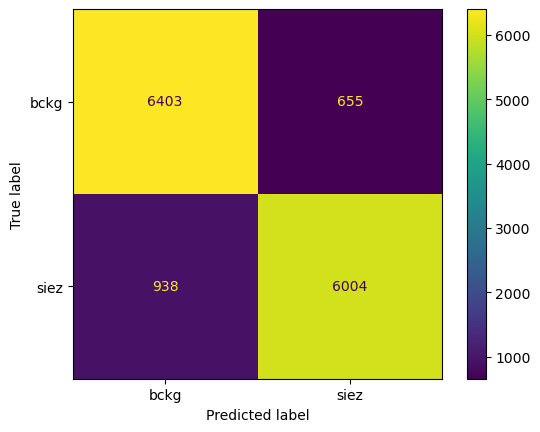

In [127]:

# using RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

clf_A = RandomForestClassifier(random_state = 42)

clf_A.fit(X_train, y_train)
predictions = clf_A.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf_A.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["bckg","siez"])
disp.plot()
plt.show()


In [133]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
actual = y_test
predicted = predictions
Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted)
Sensitivity_recall = metrics.recall_score(actual, predicted)
Specificity = metrics.recall_score(actual, predicted, pos_label=0)
F1_score = metrics.f1_score(actual, predicted)
#metrics
#print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})
# Report scores from the final model using both versions of data
print("Final Results of 14000 sessions of siezure's patients\n------")
print("Accuracy on testing data: {:.4f} %".format(Accuracy*100))
print("F-score on testing data: {:.4f}".format(F1_score))
print("Precision on testing data: {:.4f}".format(Precision))
print("Sensitivity_recall on testing data: {:.4f}".format(Sensitivity_recall))
print("Specificity on testing data: {:.4f}".format(Specificity))

Final Results of 14000 sessions of siezure's patients
------
Accuracy on testing data: 88.6214 %
F-score on testing data: 0.8829
Precision on testing data: 0.9016
Sensitivity_recall on testing data: 0.8649
Specificity on testing data: 0.9072


Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\mukht\anaconda3\envs\mne\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
119 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mukht\anaconda3\envs\mne\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mukht\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mukht\anaconda3\envs\mne\Lib\site-packages\sklearn\pipeline.py", line 47

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 300}
Best score: 0.8418749999999999


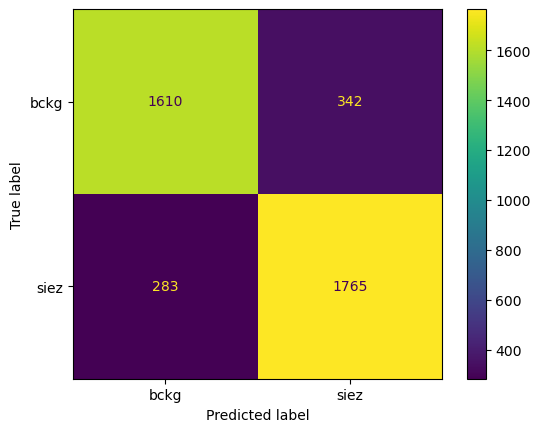

In [65]:
# Applying GridSearchCV for RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [None, 4, 6, 8, 10, 20],
    'classifier__criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
clf_Au = GridSearchCV(pipeline, param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit model
clf_Au.fit(X_train, y_train)

# Best parameters and score
print(f'Best parameters: {clf_Au.best_params_}')
print(f'Best score: {clf_Au.best_score_}')

predictions = clf_Au.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf_Au.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["bckg","siez"])
disp.plot()
plt.show()


In [9]:
from sklearn.svm import SVC
classifier = SVC(random_state=0)

from sklearn.model_selection import GridSearchCV
x = [1.0,10.0]
y = [0.1,0.2]
z = [2,3]    
parameters=[{'C': x,'kernel': ['linear']},
            {'C': x,'kernel': ['rbf'],'gamma': y} ,
            {'C': x,'kernel': ['poly'],'gamma': y,'degree': z}
           ]
gridsearch=GridSearchCV(estimator = classifier,
                        param_grid = parameters,
                        scoring='accuracy',
                        cv=2,
                        n_jobs=-1)
gridsearch=gridsearch.fit(X_train,y_train)



KeyboardInterrupt: 

In [ ]:
from sklearn.svm import SVC
classifier = SVC(random_state=0)

from sklearn.model_selection import GridSearchCV
#Using the best parameters as suggested by our GridsearchCV to finetune our model and validate it.
classifier=SVC(kernel='linear',C=1.0)
classifier.fit(X_train,y_train)
y_pred=classifier.predict(X_test)
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test,y_pred)
acc=acc*100
acc=round(acc,2)
print('Accuracy Score of our model is: ',acc,'%')

In [13]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

param_grid = {
    'clf__n_neighbors': list(range(1, 30, 2)),
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2],  # corresponds to L1 (Manhattan) and L2 (Euclidean)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring='accuracy',   # or 'f1', 'roc_auc', etc.
    n_jobs=-1,
    verbose=1,
    return_train_score=False
)

grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)
test_score = grid.score(X_test, y_test)
print("Hold-out accuracy:", test_score)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


KeyboardInterrupt: 